In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [3]:
IMAGES_PATH = Path() /"images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## load data

In [6]:
data = pd.read_hdf('data.h5', 'models/test_result/portfolio')
data.index.name = 'datetime'
data.head()

open   high    low  close    volume    dollar_vol  dollar_vol_1m  dollar_vol_rank   SMA_5     SMA_21  ...       atr  target_1d   log_clf   svm_clf   rnd_clf  mlp_clf   vot_clf   ada_clf   grb_clf  dummy_clf
ticker Date                                                                                                               ...                                                                                                     
AAL    2020-04-02  10.61  11.03  10.00  10.06   65534.6  6.592781e+05  847991.834391              5.0  11.846  13.621429  ...  3.497531  -0.068922 -0.068922 -0.068922 -0.000000     -0.0 -0.000000 -0.068922 -0.068922  -0.068922
       2020-04-03  10.34  10.49   9.09   9.39   87018.9  8.171075e+05  852792.424295              5.0  10.916  13.304762  ...  3.344901   0.011646  0.011646  0.011646  0.011646      0.0  0.000000  0.011646  0.011646   0.011646
       2020-04-06   9.72   9.94   9.11   9.50   94272.3  8.955868e+05  853989.661698              5.0  10.366  12.996667  ...  3.082575   0.073055  0.073055  0.073055  0.073055      0.0  0.073055  0.073055  0.073055   0.073055
       2020-04-07  11.07  12.20  10.05  10.22  138061.0  1.410983e+06  891287.421548              5.0   9.972  12.780952  ...  3.234634   0.103107  0.103107  0.103107  0.103107      0.0  0.103107  0.103107  0.103107   0.103107
       2020-04-08  10.91  11.40  10.50  11.33   82718.7  9.372029e+05  889795.372248              5.0  10.100  12.510952  ...  3.054236   0.099074  0.099074  0.099074  0.099074      0.0  0.000000  0.099074  0.099074   0.099074

[5 rows x 39 columns]

In [7]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dollar_vol', 'dollar_vol_1m',
       'dollar_vol_rank', 'SMA_5', 'SMA_21', 'SMA_63', 'return_1d',
       'return_5d', 'return_10d', 'return_21d', 'return_42d', 'return_63d',
       'HT_TRENDLINE', 'bb_high', 'bb_low', 'rsi', 'macd', 'PLUS_DM',
       'MINUS_DM', 'ADX', 'PPO', 'STOCH', 'MFI', 'AD', 'atr', 'target_1d',
       'log_clf', 'svm_clf', 'rnd_clf', 'mlp_clf', 'vot_clf', 'ada_clf',
       'grb_clf', 'dummy_clf'],
      dtype='object')

## Backtrader setup

## commission scheme

In [8]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

In [10]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [11]:
class SignalData(PandasData):

    cols = OHLCV + ['ada_clf'] #modify this for different classifier

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [17]:
class MLStrategy(bt.Strategy):
    params = (('n_positions', 10),
              ('min_positions', 5),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.ada_clf[0] > 0:
                    up[data._name] = data.ada_clf[0]
                elif data.ada_clf[0] < 0:
                    down[data._name] = data.ada_clf[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

### Create and configure Cerebro instance

In [18]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)

### Add input data

In [22]:
idx = pd.IndexSlice
#data = pd.read_hdf('00_data/backtest.h5', 'data').sort_index()
tickers = data.index.get_level_values(0).unique()
for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)

### Run strategy backtest

In [25]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=1, min_positions=1, 
                    verbose=True, log_file='bt_log.csv')
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 3,378,480,009.98
Duration: 00:00:05


In [28]:
# Extract inputs for pyfolio
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'ada_clf'
returns.head(2)

index
2020-04-02 00:00:00+00:00    0.0
2020-04-03 00:00:00+00:00    0.0
Name: ada_clf, dtype: float64

KeyError: "DatetimeIndex(['2020-04-02 00:00:00+00:00', '2020-04-03 00:00:00+00:00',\n               '2020-04-06 00:00:00+00:00', '2020-04-07 00:00:00+00:00',\n               '2020-04-08 00:00:00+00:00', '2020-04-09 00:00:00+00:00',\n               '2020-04-13 00:00:00+00:00', '2020-04-14 00:00:00+00:00',\n               '2020-04-15 00:00:00+00:00', '2020-04-16 00:00:00+00:00',\n               ...\n               '2022-12-15 00:00:00+00:00', '2022-12-16 00:00:00+00:00',\n               '2022-12-19 00:00:00+00:00', '2022-12-20 00:00:00+00:00',\n               '2022-12-21 00:00:00+00:00', '2022-12-22 00:00:00+00:00',\n               '2022-12-23 00:00:00+00:00', '2022-12-27 00:00:00+00:00',\n               '2022-12-28 00:00:00+00:00', '2022-12-29 00:00:00+00:00'],\n              dtype='datetime64[ns, UTC]', name='index', length=692, freq=None) not in index"

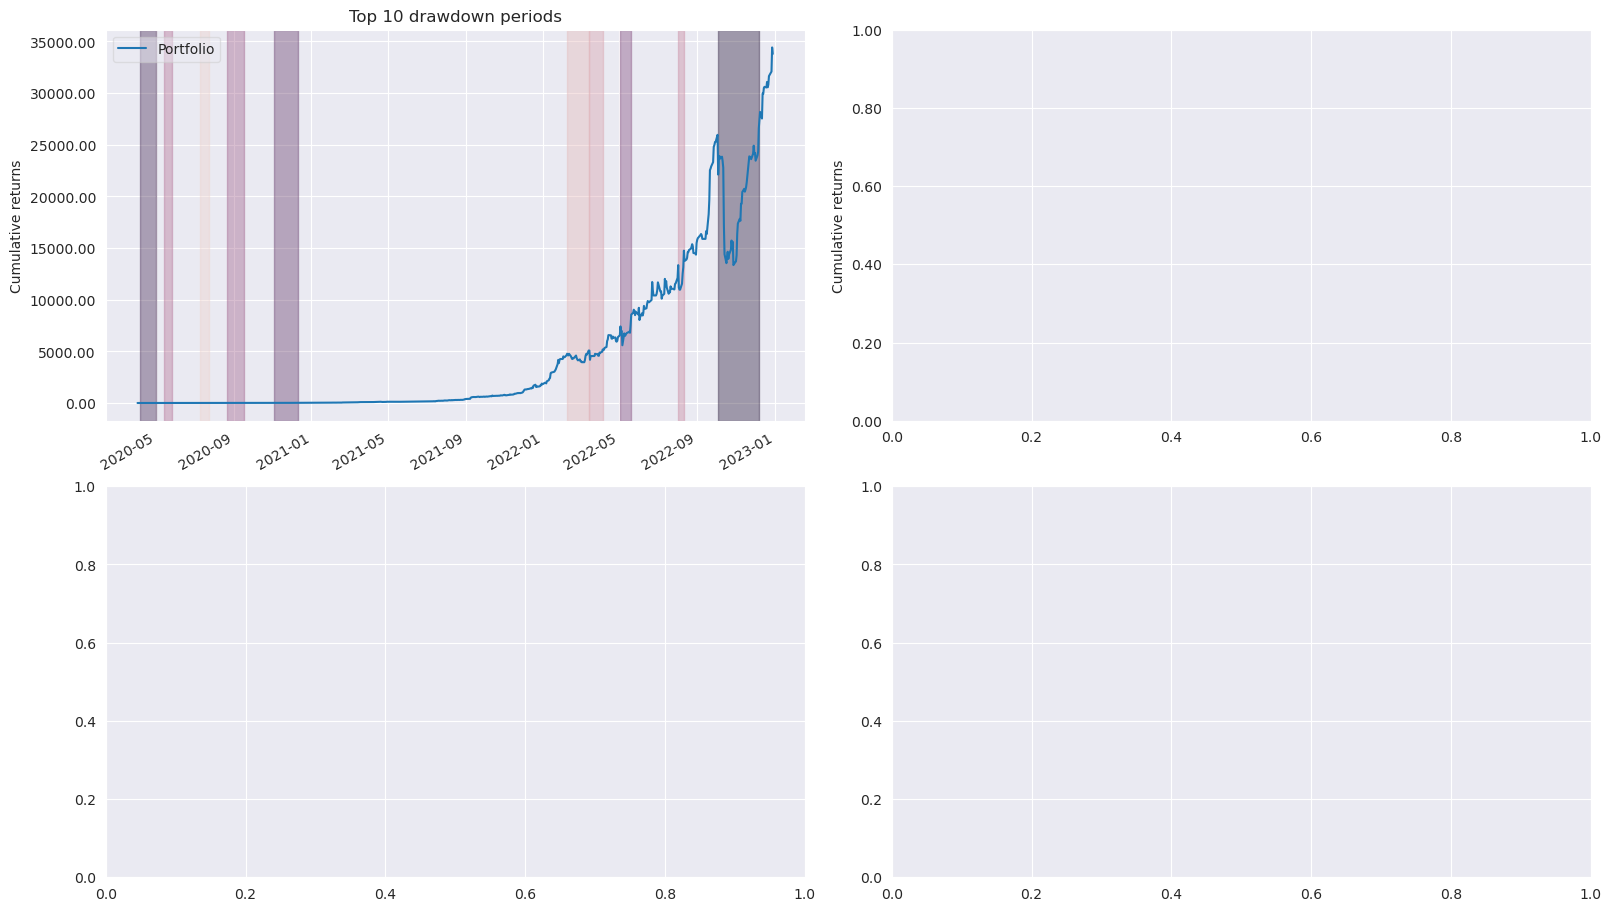

In [39]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
pf.plot_drawdown_periods(returns=returns, ax=axes[0])
pf.plot_rolling_returns(returns=returns,
                        factor_returns=passive_rets,
                        ax=axes[1], 
                        title='Cumulative returns on {} vs {}'
                        .format(returns.name, passive_rets.name))
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])


plt.legend()
plt.tight_layout()


In [49]:
pf.show_perf_stats(returns=returns, positions=positions, transactions=transactions)

Start date,2020-04-02
End date,2022-12-29
Total months,32
,Backtest
Annual return,14.157%
Cumulative returns,43.848%
Annual volatility,29.588%
Sharpe ratio,0.60
Calmar ratio,0.71
Stability,0.78
Max drawdown,-20.016%


## Save results

In [50]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

#export
returns.to_hdf('backtrader.h5', 'pyfolio/{}/{}/returns'.format(tick,strat))
positions.to_hdf('backtrader.h5', 'pyfolio/{}/{}/positions'.format(tick,strat))
transactions.to_hdf('backtrader.h5', 'pyfolio/{}/{}/transactions/'.format(tick,strat))
gross_lev.to_hdf('backtrader.h5', 'pyfolio/{}/{}/gross_lev'.format(tick,strat))

##  pyfolio analysis

In [30]:
benchmark = pd.read_hdf('./assets.h5', 'yfinance/index/vtsax')

In [31]:
benchmark.index.name = 'datetime'
benchmark_rets = benchmark['Adj Close'].pct_change()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'VTSAX'
benchmark_rets.head(2)

datetime
2020-04-02 00:00:00+00:00    0.020558
2020-04-03 00:00:00+00:00   -0.016541
Name: VTSAX, dtype: float64

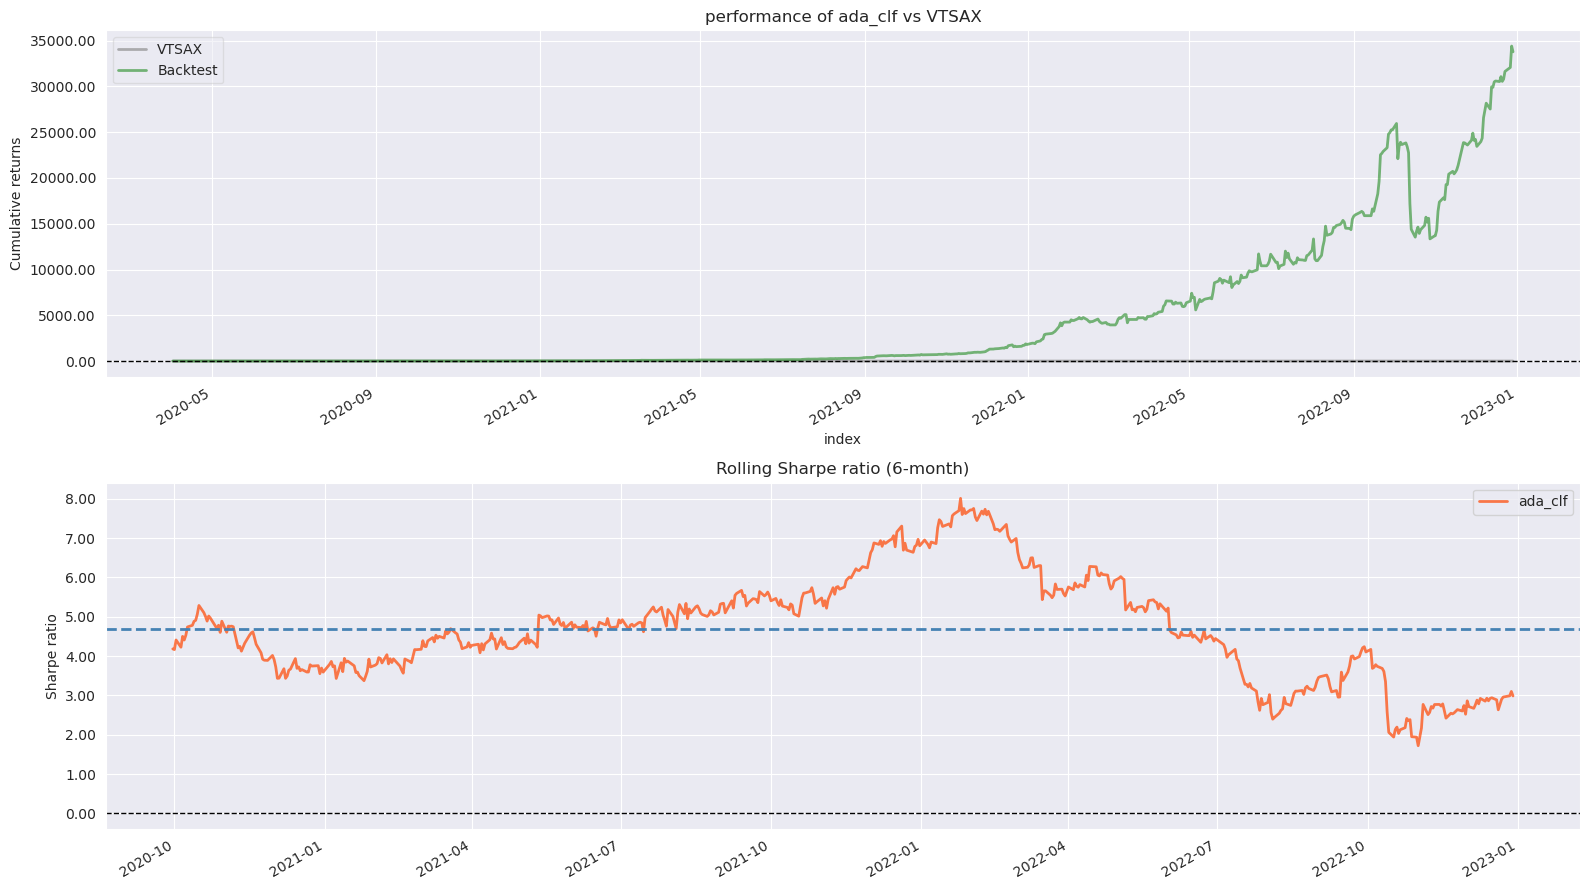

In [34]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[0], 
                        title='performance of {} vs {}'
                       .format(returns.name,benchmark_rets.name))
axes[1].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[1])

plt.grid(True)
plt.legend()
plt.tight_layout()

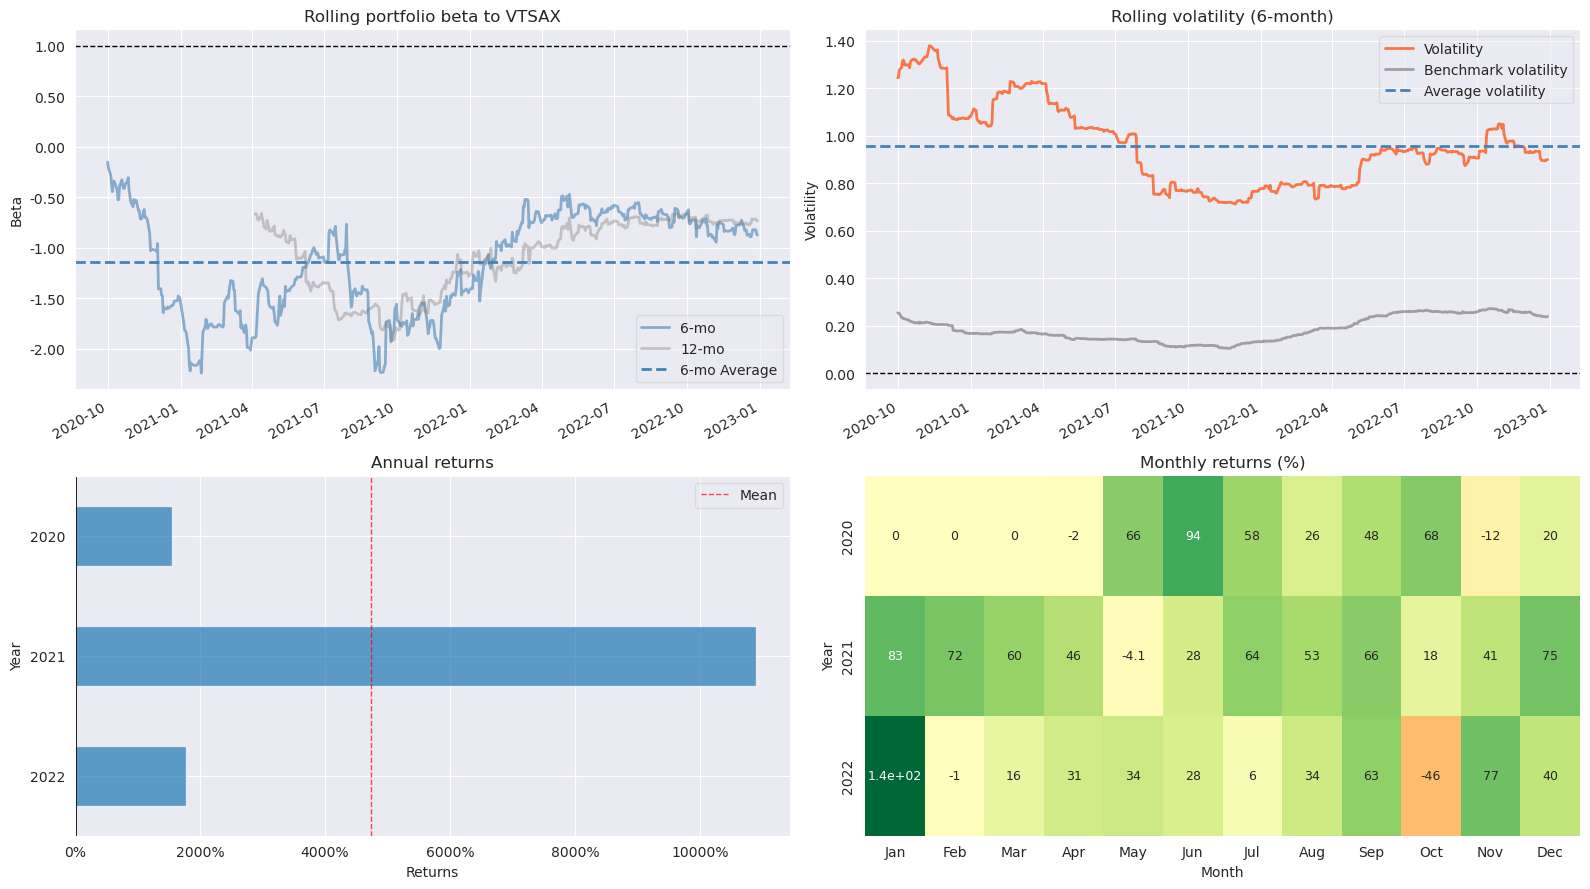

In [36]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
pf.plot_annual_returns(returns=returns, ax=axes[2])
pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)

plt.tight_layout()
save_fig("pyfolio_results_{}_{}".format(returns.name,benchmark_rets.name))

Start date,2020-04-02
End date,2022-12-29
Total months,32
,Backtest
Annual return,4358.487%
Cumulative returns,3378380.01%
Annual volatility,100.166%
Sharpe ratio,4.30
Calmar ratio,89.74
Stability,0.99
Max drawdown,-48.567%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,48.57,2022-10-03,2022-10-28,2022-12-07,48
1,28.00,2020-04-06,2020-04-17,2020-05-01,20
2,25.84,2020-11-03,2020-11-11,2020-12-11,29
3,24.60,2022-05-03,2022-05-06,2022-05-19,13
4,20.30,2020-08-21,2020-08-28,2020-09-16,19


Stress Events,mean,min,max
Covid,1.71%,-24.42%,37.37%


Top 10 long positions of all time,max
sid,
AAL,189086.04%
MSFT,24313.80%
NKE,17095.15%
AAPL,2866.30%
ZG,999.93%
DIS,463.07%


Top 10 short positions of all time,max
sid,
AAL,-103994.23%
NKE,-50003.83%
MSFT,-49996.88%
AAPL,-22814.32%
ZG,-3371.74%
DIS,-1018.71%


Top 10 positions of all time,max
sid,
AAL,189086.04%
NKE,50003.83%
MSFT,49996.88%
AAPL,22814.32%
ZG,3371.74%
DIS,1018.71%


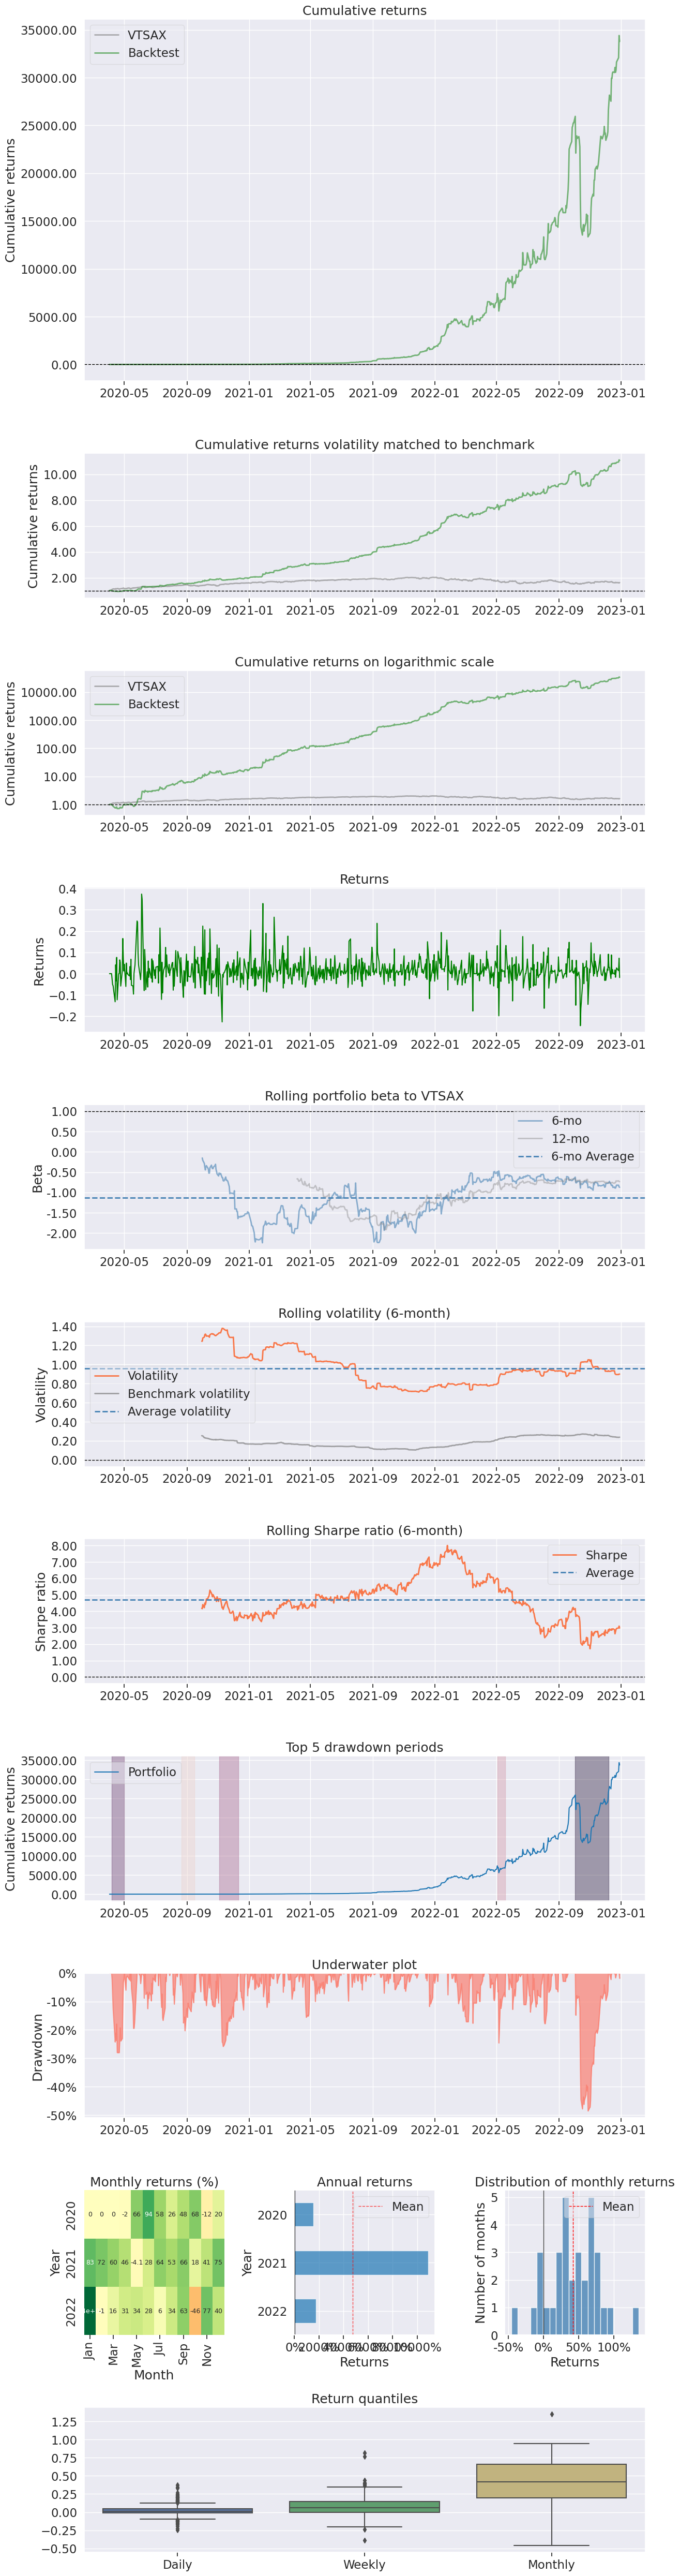

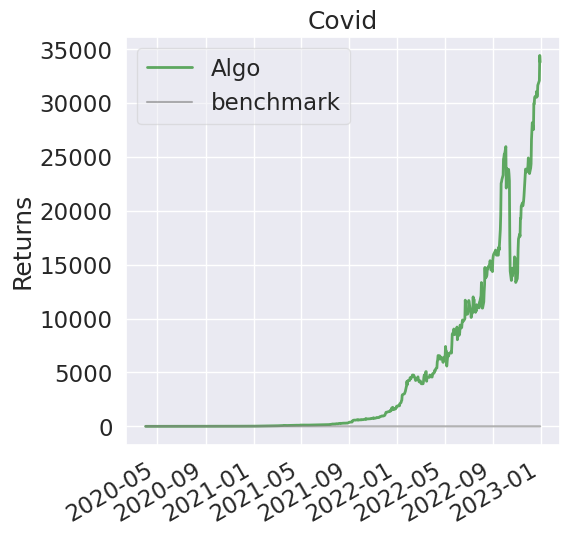

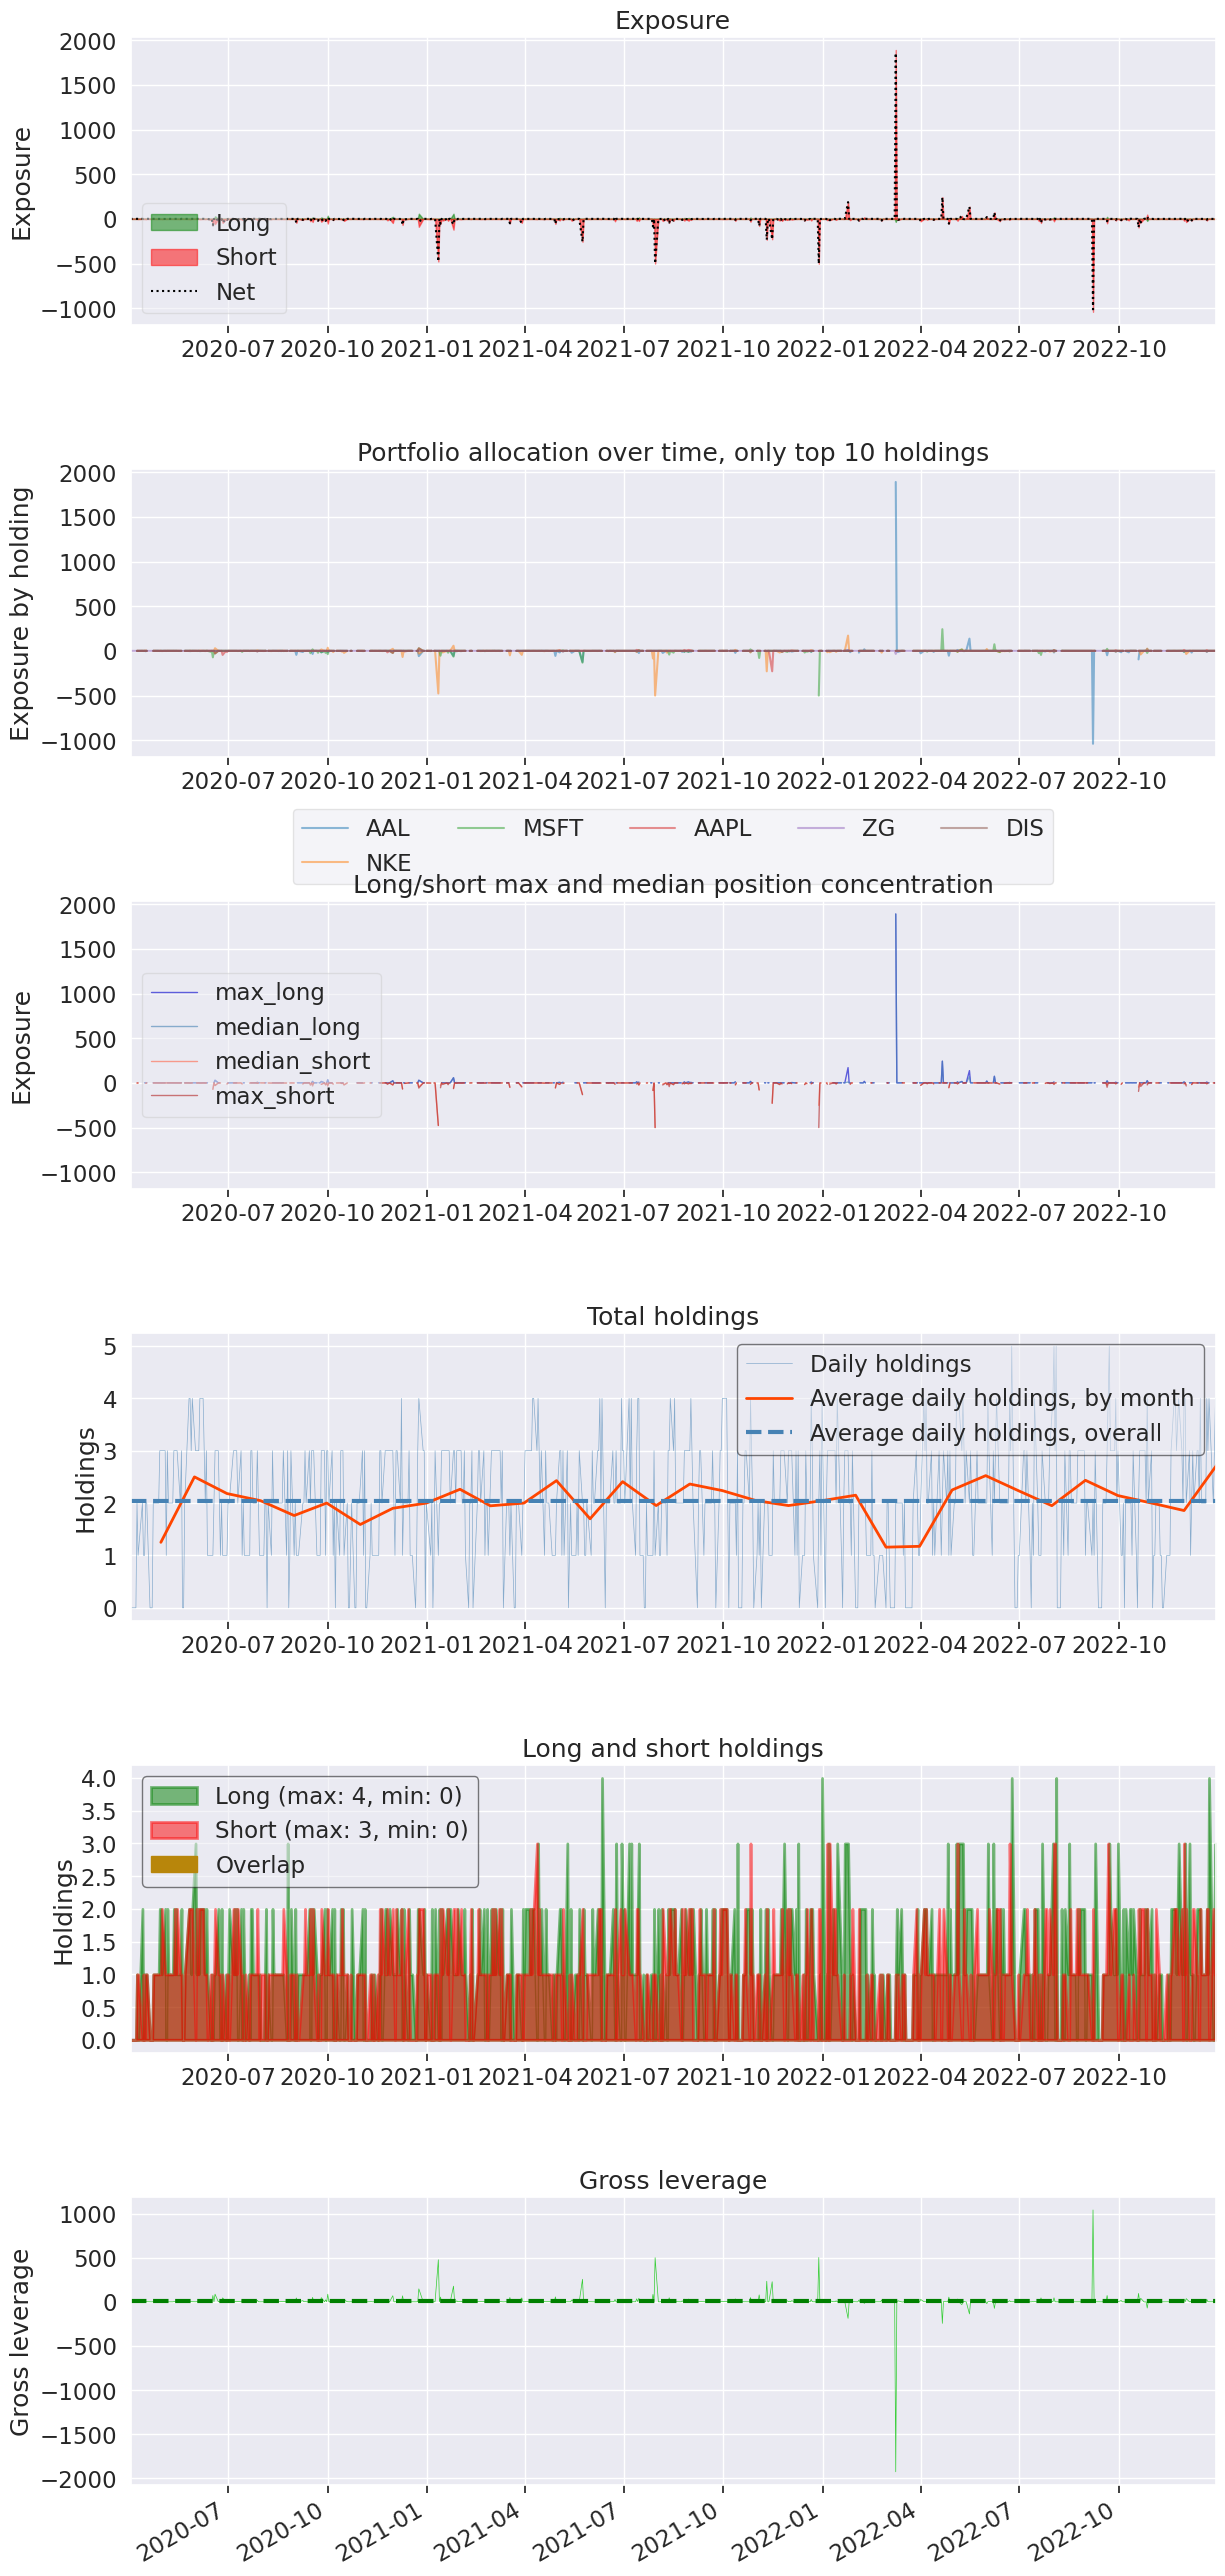

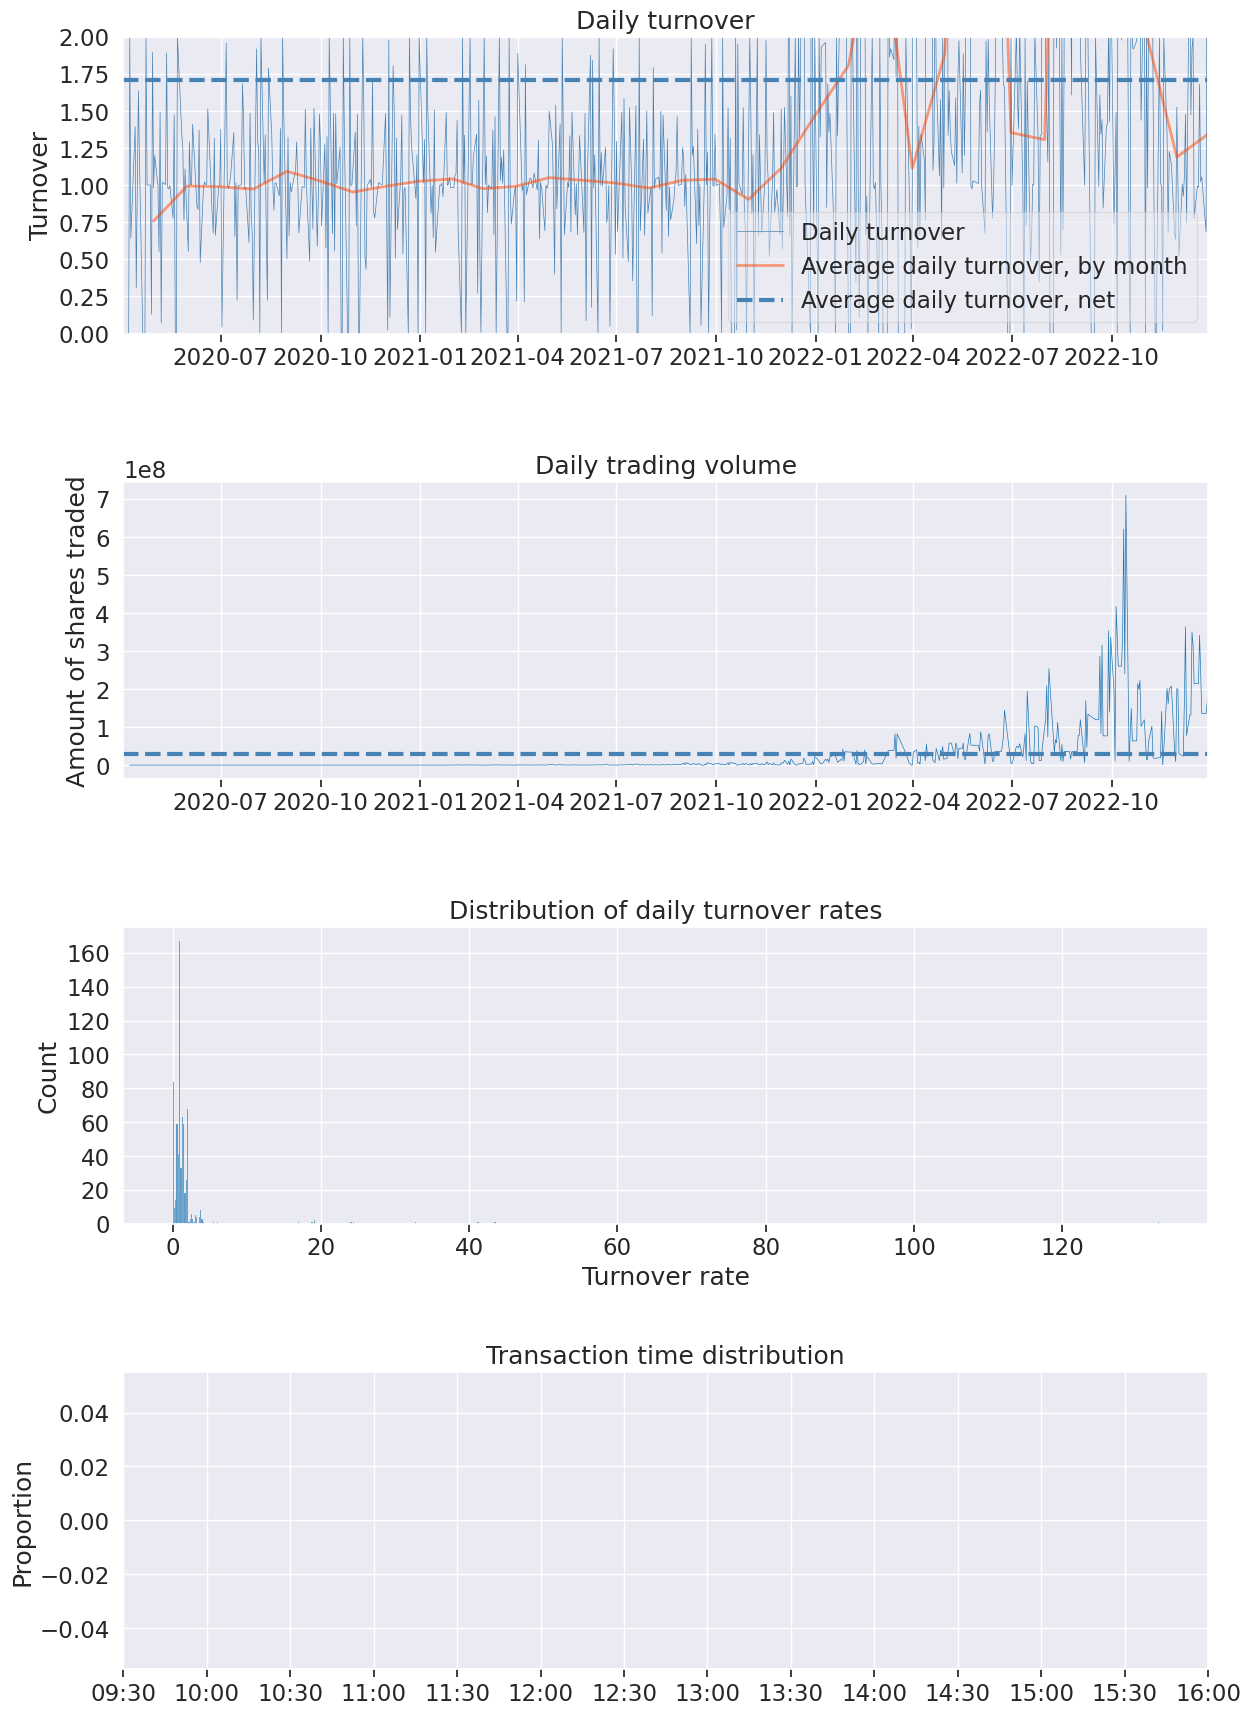

In [37]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark_rets.dropna())